In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import random

# L'algorithme du recuit simulé

L'algorithme du recuit simulé permet de résoudre des problèmes d'optimisation non convexe, pour lesquels la méthode de descente du gradient n'est pas appropriée. On s'intéresse ici à une application au problème du voyageur de commerce (section 6.4 dans le poly).

## 1) Données numériques
On souhaite calculer le **plus court chemin cyclique** passant par toutes les capitales des états fédéraux américains (Hawaii et Alaska exclus). Ce problème provient de la collection d'exemples [TSPLIB](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html). Les données dont on dispose sont les cordonnées géographiques des villes, regroupées dans une matrice `uscapitals_list` :

In [2]:
uscapitals_list = np.genfromtxt("uscapitals.csv", delimiter=",")

La i-ème ligne de la matrice `uscapitals_list` est le couple de coordonnées de la i-ème ville. Par exemple :

In [3]:
print(uscapitals_list[3])

[401. 841.]


Dans l'exemple que nous considérons ici, le parcours optimal est connu et stocké dans la variable `uscapitals_opt` :

In [4]:
uscapitals_opt = np.genfromtxt("uscapitals_opt.csv", delimiter=",").astype(np.int)-1
print(uscapitals_opt)

[ 0  7 37 30 43 17  6 27  5 36 18 26 16 42 29 35 45 32 19 46 20 31 38 47
  4 41 23  9 44 34  3 25  1 28 33 40 15 21  2 22 13 24 12 10 11 14 39  8]


Pour calculer la distance (en milles) entre les villes à partir de leurs cordonnées, on utilise la distance euclidienne classique :

In [5]:
def pseudo_euclidian_dist(citya, cityb):
    return np.linalg.norm(cityb-citya)

In [6]:
uscapitals_distances = np.zeros((len(uscapitals_list),
                                 len(uscapitals_list)))
for i in range(len(uscapitals_list)):
    for j in range(len(uscapitals_list)):
        uscapitals_distances[i,j] = pseudo_euclidian_dist(uscapitals_list[i], uscapitals_list[j])

In [7]:
cities = uscapitals_list
optimal = uscapitals_opt
distances = uscapitals_distances

## 2) L'algorithme
**Objectif à minimiser** Le coût $V$ d'un parcours est la somme des distances entres villes consécutives. On identifie un parcours avec une permutation $\sigma$ de l'ensemble $\{0,2,..,15\}$, que l'on représente par une liste. $\sigma(k)$ est donc la k-ème ville que l'on visite en suivant le parcours $\sigma$.

**TODO** : La fonction `V` le tableau de l'ordre des villes `tour` et la matrice `distances`des distances entre villes, et retourne un nombre réel `c`.

In [40]:
def V(tour, distances):
    c = 0
    for i in range(len(tour)-1):
        c = c + distances[tour[i], tour[i+1]]

    c = c + distances[tour[len(tour)-1], tour[0]]
    return c

**Algorithme du recuit simulé** À chaque itération, l'algorithme propose un nouveau parcours, obtenu en tirant au hasard deux nombres $i$ et $j$ et en invertissant les villes $\sigma(i)$ et $\sigma(j)$ dans l'état courant.

**TODO** : La fonction `proposition` prend un tableau d'ordre des villes et retourne un nouveau tableau permuté. Par exemple, `proposition([0,1,2,3,4])` pourrait produire `[1,0,2,3,4]`.

In [41]:
def proposition(tour):
    prop = tour.copy()
    idx = range(len(tour))
    i1, i2 = random.sample(idx, 2)
    prop[i1], prop[i2] = prop[i2], prop[i1]
    return prop
print("Exemple :", [0,1,2,3,4], "->", proposition([0,1,2,3,4]))

Exemple : [0, 1, 2, 3, 4] -> [0, 3, 2, 1, 4]


Le deuxième ingrédient est le schéma de température, qui régit la décroissance de la température au cours du temps. Plusieurs choix sont possibles. On utilise pour commencer une décroissance polynomiale :

In [42]:
def T(i):
    return 300*((i+1)**(-0.03))

**TODO** : Dans la fonction suivante, on implémente l'algorithme. Les arguments sont
- la matrice des distances entre villes `distances`
- le nombre d'itérations `N_iter`
- l'état initial `initial_tour`
- une fonction de proposition de changement `proposition`
- une fonction `T` pour le schéma de température


La fonction retourne 
- l'état final `tour` après `N_iter` étapes 
- l'état  `best` qui a la valeur minimale pour la fonction coût (`V`) parmi tous les états visités 
- la liste `costseq` des valeurs de la fonction coût à chaque étape de l'algorithme
- la liste `bestseq` des meilleures valeurs dans la fonction coût trouvées par l'algorithme

In [43]:
def recuit_simule(distances, N_iter, initial_tour, proposition, T):
    tour = initial_tour
    best = initial_tour
    costseq = [V(initial_tour, distances)]
    bestseq = [V(initial_tour, distances)]

    for n in range(N_iter):
        prop = proposition(tour)
        U = np.random.rand()

        if U <= min(1, np.exp(-(V(prop, distances)-V(tour, distances)) / (T(n)))):
            tour = prop

        if V(tour, distances) <= V(best, distances):
            best = tour

        costseq.append(V(tour, distances))
        bestseq.append(V(best, distances))

    return tour, best, costseq, bestseq

Une collection d'états initiaux possibles est stockée dans la liste `problem_initial_tours` : le $i$-ème élément est obtenu en appliquant $i$ transpositions aléatoires au parcours optimal.

In [45]:
problem_initial_tours = []
for i in range(10):
    problem_initial_tours.append(optimal.copy())
    for k in range(i):
        problem_initial_tours[i] = proposition(problem_initial_tours[i])

On peut à présent tester l'algorithme et visualiser la décroissance dans la fonction objectif :

In [46]:
N_iter = 10000
i = 9
initial_tour = problem_initial_tours[i]

tour, best, cseq, bseq = recuit_simule(distances, N_iter, initial_tour, proposition, T)

In [51]:
def plot_recuit(cseq, bseq, best, optimal, legend=True, label=""):
    p1 = plt.axhline(V(optimal, distances), label='Valeur optimale', c="black", ls="--")
    p2, = plt.plot(cseq, label='V(X_n) '+label)
    p3, = plt.plot(bseq, label='V(Best_n) '+label)
    if legend:
        plt.legend(fontsize=12)
        plt.ylabel("Fonction objectif", fontsize=12)
        plt.xlabel("Nombre d'itérations", fontsize=12)

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 11996.483996232637


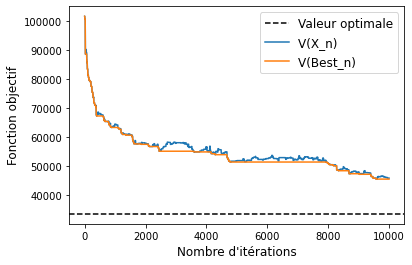

In [52]:
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal)

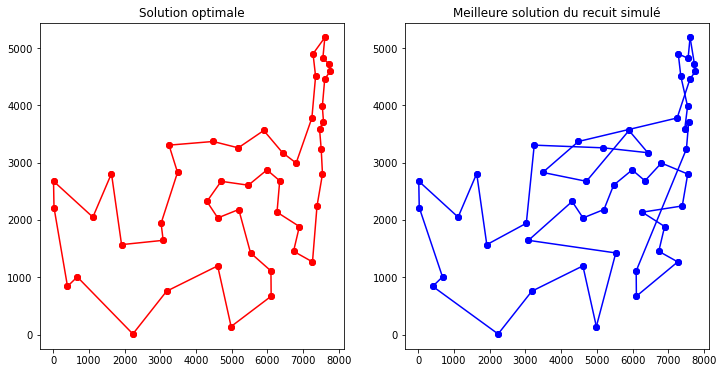

In [53]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[best[i], 0], cities[best[i+1], 0]]),
             np.array([cities[best[i], 1], cities[best[i+1], 1]]), '-bo')

plt.plot(np.array([cities[best[total-1], 0], cities[best[0], 0]]), np.array(
    [cities[best[total-1], 1], cities[best[0], 1]]), '-bo')
plt.show()

## 3) Rôle de la proposition de changement

Dans la partie précédente, nous avons considéré la proposition de changement consistant à intervertir deux villes choisies au hasard. D'autres propositions sont possibles. Par exemple, au lieu d'intervertir deux villes, on peut en intervertir $k > 1$.

Une autre possibilité consiste à choisir deux villes $i,j$ au hasard et à les intervertir dans le parcours, ainsi que toutes les villes entre les deux.

**TODO** : implémenter la fonction `proposition_reverse`, qui prend un tableau d'ordre des villes et retourne un tableau permuté. Par exemple, `proposition_reverse([0, 1, 2, 3, 4, 5, 6])` pourrait produire `[0, 1,  5, 4, 3, 2, 6]`.

In [19]:
def proposition_reverse(tour):
    idx = range(len(tour))
    i1, i2 = random.sample(idx, 2)
    i1, i2 = min(i1,i2), max(i1,i2)
    prop = tour.copy()
    prop[i1:i2+1] = tour[i1:i2+1][::-1]
    return prop
print("Exemple :", [0,1,2,3,4,5,6], "->", proposition_reverse([0,1,2,3,4,5,6]))

Exemple : [0, 1, 2, 3, 4, 5, 6] -> [0, 1, 4, 3, 2, 5, 6]


La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 3389.7825214859695


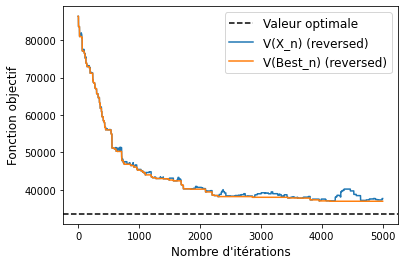

In [20]:
tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed)")

Enfin, on peut raffiner la règle `proposition_reverse` pour favoriser les interversions entre sommets proches dans l'itinéraire.
Par exemple, étant donné un sommet aléatoire $i$, on choisit le sommet $j$ avec probabilité $\frac C{|i-j|+1}$, avec $C$ une constante de normalisation.

**TODO** : adapter la fonction `proposition_reverse` pour ajouter une pondération dans le choix des sommets (on pourra utiliser la fonction `np.choice`).

In [21]:
def proposition_reverse_weighted(tour):
    idx = np.arange(len(tour))
    i1 = random.randint(0,len(tour)-1)
    probas = 1/(1+np.abs(i1-idx))
    probas[i1] = 0
    probas /= probas.sum()
    i2 = int(np.random.choice(idx, p=probas))
    i1, i2 = min(i1,i2), max(i1,i2)
    prop = tour.copy()
    prop[i1:i2+1] = tour[i1:i2+1][::-1]
    return prop
print("Exemple :", [0,1,2,3,4,5,6], "->", proposition_reverse_weighted([0,1,2,3,4,5,6]))

Exemple : [0, 1, 2, 3, 4, 5, 6] -> [0, 1, 3, 2, 4, 5, 6]


La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 3026.477403354562


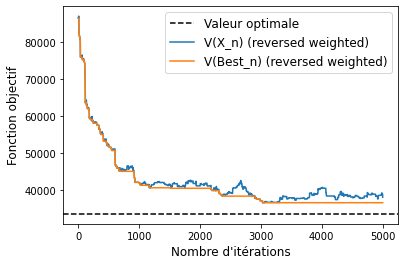

In [22]:
tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed weighted)")

Les méthodes `proposition_reverse` et `proposition_reverse_weighted` donnent des résultats proches à première vue. Pour les comparer, on effectue chaque simulation 50 fois et compare les histogrammes des performances :

In [23]:
gaps_reverse = []
for _ in range(50):
    tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
    gap = V(best, distances) - V(optimal, distances)
    gaps_reverse.append(gap)

In [24]:
gaps_reverse_weighted = []
for _ in range(50):
    tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
    gap = V(best, distances) - V(optimal, distances)
    gaps_reverse_weighted.append(gap)

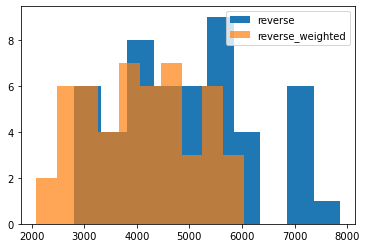

In [24]:
plt.hist(gaps_reverse ,label="reverse")
plt.hist(gaps_reverse_weighted, label="reverse_weighted", alpha=0.7)
plt.legend()
plt.show()

## 4) Schéma de température

On a utilisé jusqu'ici le schéma de température $T(i) = 300(i+1)^{-0.03}$ à décroissance polynomiale. D'autres choix sont bien sûr possibles.
On peut par exemple varier les constantes du schéma $T_{polynomial}(i) = a(i+1)^b$ :

In [25]:
def T_polynomial(a, b):
    def T(i):
        return a*((i+1)**b)
    return T

On peut maintenant tester la performance de l'algorithme du recuit simulé sur plusieurs valeurs de $a$ et $b$ :

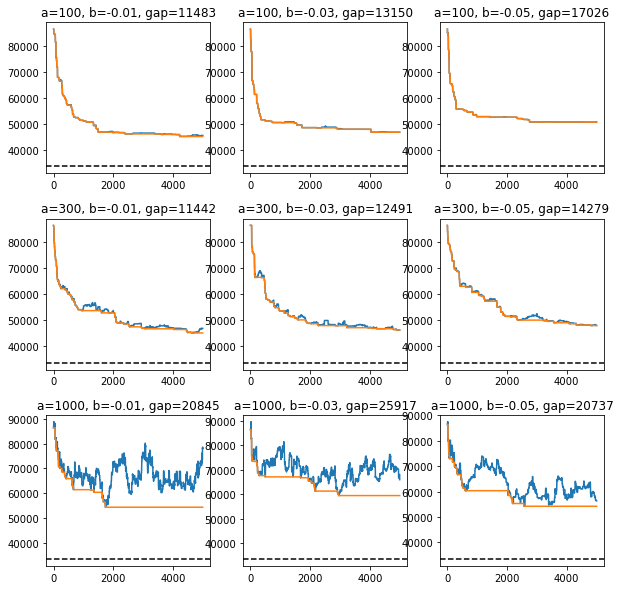

In [27]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [100, 300, 1000]:
    for b in [-0.01, -0.03, -0.05]:
        T = T_polynomial(a, b)
        tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = V(best, distances) - V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

A titre de comparaison, on peut également tester un schéma de température à décroissance exponentielle $T_{exponential}(i) = a*b^i$ (avec $0<b<1$).

In [28]:
def T_exponential(a, b):
    def T(i):
        return a*(b**i)
    return T

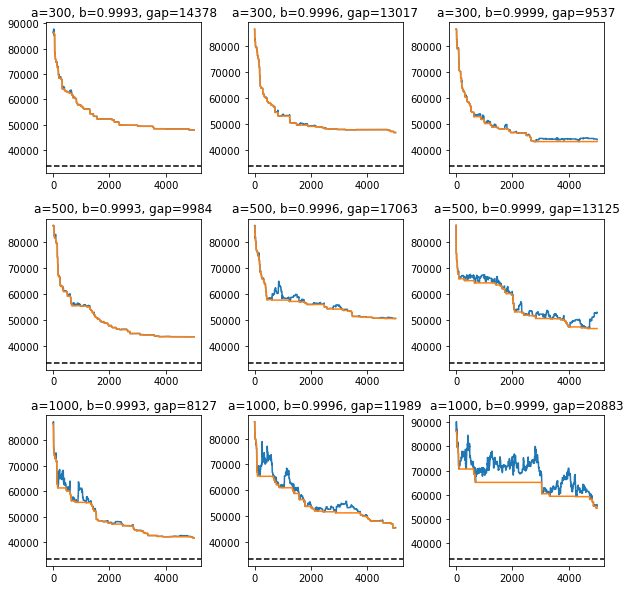

In [29]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
i = 1
for a in [300, 500, 1000]:
    for b in [0.9993, 0.9996, 0.9999]:
        T = T_exponential(a, b)
        tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = V(best, distances) - V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

On peut aussi utiliser des schémas non décroissants : l'idée est alors d'alterner les phases de réchauffement et de refroidissement. On essaye ici $T_{oscillatory}(i) = a(i+1)^b(\cos((2\pi i)/c)^2+d)$.

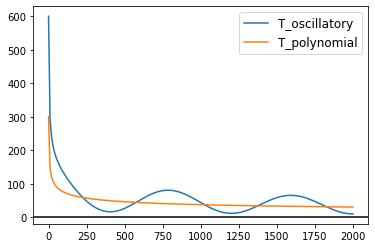

In [30]:
def T_oscillatory(a, b, c, d):
    def T(i):
        return a*((i+1)**b)*(np.cos(2*np.pi*i/c)**2 + d)
    return T

x = np.linspace(0,2000,200)
plt.plot(x, T_oscillatory(500,-0.3,1600,0.2)(x), label="T_oscillatory")
plt.plot(x, T_polynomial(300,-0.3)(x), label="T_polynomial")
plt.axhline(0, c="black")
plt.legend(fontsize=12)
plt.show()

**TODO** : observer le comportement du schéma de température oscillant et l'influence des paramètres du schéma sur le résultat.

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 8415.998144456287


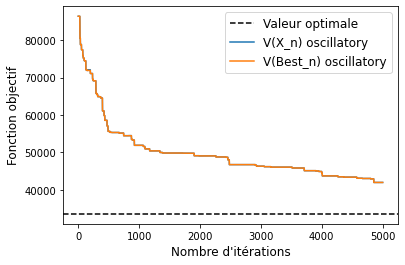

In [31]:
tour, best, cseq, bseq = recuit_simule(distances, 5000, initial_tour, proposition, T_oscillatory(600,-0.4,1600,0.3))
gap = V(best, distances) - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="oscillatory")

## 5) Pour aller plus loin...

Vous pouvez tester l'algorithme sur des instances plus difficiles. Les données sont organisées comme celles du problème `us_capitals`.
- Le problème `gr96` consiste à calculer le plus court cycle reliant 96 villes en Afrique
- Le problème `tsp225` relie 225 villes générées automatiquement

Dans le jeux de données `gr96`, les villes sont données en coordonnées sphériques (latitude, longitude). Pour calculer les distances entre villes, on utilise la fonction `earth_dist`, définie ci-dessous à l'aide du module `geopy` ([disponible](https://pypi.org/project/geopy/) via `pip`) :

In [31]:
from geopy import distance

def earth_dist(citya, cityb):
    return distance.distance(citya, cityb).miles

In [32]:
gr96_list = np.genfromtxt("gr96.csv", delimiter=",")
gr96_opt = np.genfromtxt("gr96_opt.csv", delimiter=",").astype(np.int)-1
gr96_distances = np.array([[earth_dist(ca, cb) for ca in gr96_list] for cb in gr96_list])

In [33]:
tsp225_list = np.genfromtxt("tsp225.csv", delimiter=",")
tsp225_opt = np.genfromtxt("tsp225_opt.csv", delimiter=",").astype(np.int)-1
tsp225_distances = np.array([[np.linalg.norm(ca-cb) for ca in tsp225_list] for cb in tsp225_list])

In [34]:
cities = gr96_list
optimal = gr96_opt
distances = gr96_distances

## 6) Conclusions
1. Que fait l'algorithme du recuit simulé ? Pour quels types de problèmes est-il pertinent ?

2. Quel est le rôle de la proposition de changement ? Comment la choisir ?

3. Quel est le rôle du schéma de température ? Comment le choisir ?